# Rotating reference frame

As discussed in Viscous flow about a moving body, it is slower
to solve the problem when the body moves in our frame of reference, because
it requires re-generating the grid operations at each time step. However,
when we only have a single rigid body, we can solve the problem in a
frame of reference moving with the body. In this manner, the body
remains invariantly mmersed in the grid, so the problem is faster to solve.

We will demonstrate how to solve a problem in a moving reference frame in this
notebook. First, we need some notation, given by the diagram below:

![comoving-diagram.svg](./assets/comoving-diagram.svg)

The main idea is that we wish to solve the problem in the $(\hat{x},\hat{y})$
reference frame, moving with the body. In that reference frame, the
translational $\mathbf{U}_p$ and rotational $\Omega$ motion of the body appear as effects at infinity.
This is fine for the translational part -- it's equivalent to a freestream velocity.
However, it is problematic for the rotational part in external flows, because the velocity's magnitude grows
with distance from the center of rotation. Instead, we solve for the
velocity expressed relative to the translating frame, but *not the rotating frame*.
However, the components of this velocity are still expressed in the rotating
coordinate system, $\hat{x}$ and $\hat{y}$.

Mathematically, we write this velocity as $\mathbf{u}' = R^T (\mathbf{u} - \mathbf{U}_p)$.
where $R$ is the rotation operator from the rotating to the inertial coordinate
system. The boundary conditions on $\mathbf{u}'$ are $-R^T \mathbf{U}_p$ at
infinity (a freestream), and $\mathbf{u}' = \Omega \times (\mathbf{x}-\mathbf{X}_p)$
on the surface of the body.

To set the problem up, we simply need to supply the kinematics of the
reference frame (through a "reference frame" key in the parameters Dict),
and the center of rotation, expressed in the co-moving coordinates, $\hat{X}_p$
(through the "center of rotation" key).

Here, we will demonstrate this on a problem involving the flapping of a
flat plate. (This is a simple model for hovering insect flight, if you're
interested!)

In [1]:
using ViscousFlow

In [2]:
using Plots

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [3]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, motion_state(bc,$m)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                global x += motion_velocity(bc,$m,t)*$dt
                update_body!(bc,x,$m)
                plot(bc,xlim=$xlim,ylim=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

Set the Reynolds number

In [4]:
my_params=Dict()
my_params["Re"] = 100

100

### Set the kinematics
Here, we will define the kinematics. The wing will pitch about
an axis at its leading edge, as in the figure below

![flat-plate-diagram.svg](./assets/flat-plate-diagram.svg)

Thus, $\hat{X}_p = (0,0.5c)$. We will scale the problem by $c$,
so we will set this center at $(0,0.5)$ in the scaled coordinates

In [5]:
Xp, Yp = 0.0, 0.5

(0.0, 0.5)

Set the frequency and amplitude of flapping

In [6]:
Ω = π/2 # Flapping frequency
Tp = 2π/Ω # Period of flapping
Δα = π/4 # Amplitude of pitching
Ax, Ay = 1.0, 0.0  # Amplitude of heaving (only horizontal)

(1.0, 0.0)

Set the phase lag of the heaving to pitching to 90 degrees

In [7]:
ϕx, ϕy = -π/2, 0.0
ϕα = 0.0

0.0

Constant translation/rotation, not important here

In [8]:
α₀ = α̇ = Ux = Uy = 0.0

0.0

Create the motion, and set the center of rotation
and motion into the Dict

In [9]:
kin = Oscillation(Ux,Uy,α̇,Xp,Yp,Ω,Ax,Ay,ϕx,ϕy,α₀,Δα,ϕα)
mot = RigidBodyMotion(kin)
my_params["center of rotation"]=(Xp,Yp)
my_params["reference frame"] = mot

#= Create a domain big enough to hold the vorticity.
We will loosen the grid Re a bit.
=#
xlim = (-4.0,4.0)
ylim = (-2.5,3.0)
my_params["grid Re"] = 3.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((270, 192), (135, 88), 0.03, ((-4.02, 4.02), (-2.61, 3.09)))

Create the plate and rotate it so that it is vertical

In [10]:
Δs = surface_point_spacing(g,my_params)
body = Plate(1.0,Δs)
T = RigidTransform((0.0,0.0),π/2)
T(body)

Open polygon with 2 vertices and 24 points
   Current position: (0.0,0.0)
   Current angle (rad): 1.5707963267948966


Now animate the motion for a complete cycle (4 time units)

┌ Warning: `parse(::Type, ::Coloarant)` is deprecated.
│   Do not call `parse` if the object does not need to be parsed.
│   caller = font(; kw::Base.Pairs{Symbol, Any, NTuple{6, Symbol}, NamedTuple{(:family, :pointsize, :valign, :halign, :rotation, :color), Tuple{String, Int64, Symbol, Symbol, Float64, ColorTypes.RGB{FixedPointNumbers.N0f8}}}}) at components.jl:297
└ @ Plots ~/.julia/packages/Plots/Hxe7H/src/components.jl:297
[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_VyZwR6zs9Q.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_VyZwR6zs9Q.gif")
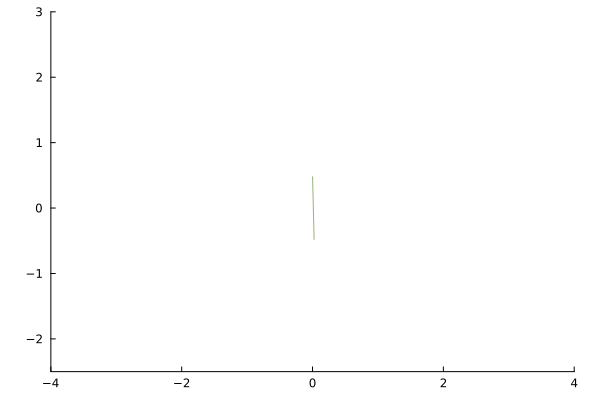

In [11]:
@animate_motion body mot Tp/200 Tp xlim ylim

We can also plot the kinematics

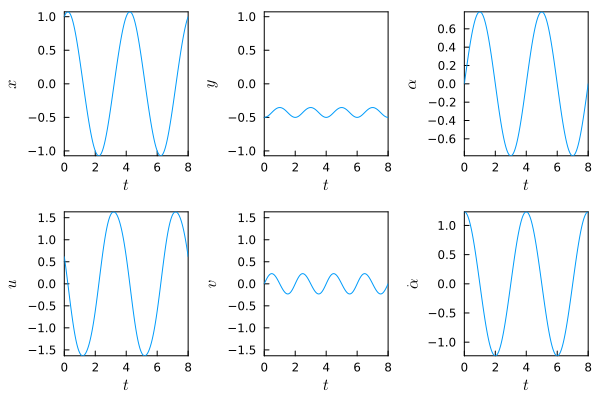

In [12]:
plot(mot;tmax=8)

### Set the boundary conditions
We need to provide specialized boundary conditions for this problem,
and we use the function surface_velocity_in_translating_frame!
for that. Because we are simulating a flat plate, both the positive
and negative sides of the surface must have their boundary velocities
set the same way. If this were instead a closed body, we would set either
the positive or negative side's value to zero.

In [13]:
function my_vsplus(t,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,t,base_cache,phys_params)
  return vsplus
end

function my_vsminus(t,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsminus,t,base_cache,phys_params)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Set up the system structure and initial conditions
This is done the usual way

In [14]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict);
u0 = init_sol(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 270, ny = 192) cell grid of type Float64 data
  Number of Dual nodes: (nx = 270, ny = 192), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Solve the problem
Here, we will advance it for one flapping period

In [15]:
step!(integrator,Tp)

### Plot it
Plot the vorticity field

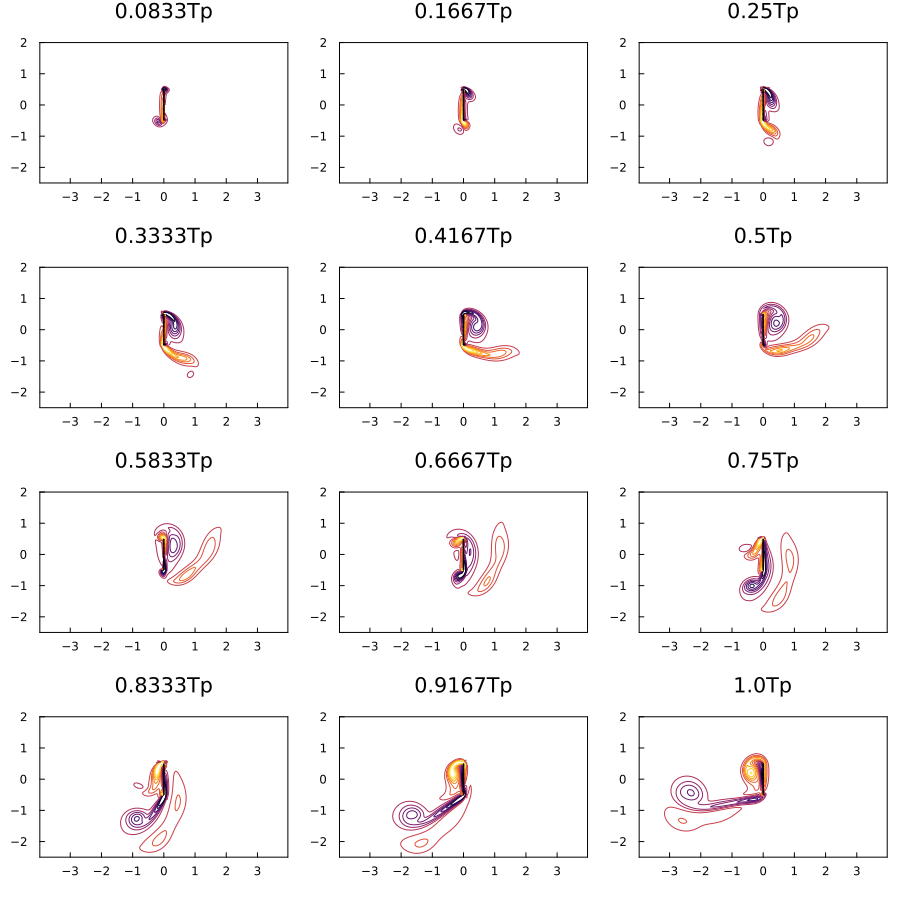

In [16]:
sol = integrator.sol
plt = plot(layout = (4,3), size = (900, 900), legend=:false)
tsnap = Tp/12:Tp/12:Tp
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,clim=(-20,20),levels=range(-20,20,length=16),ylim=(-2.5,2),title="$(round(t/Tp,digits=4))Tp")
end
plt

### Plot the forces and moments
The solution is expressed in rotating coordinates, so we have
to convert the force components to inertial coordinates

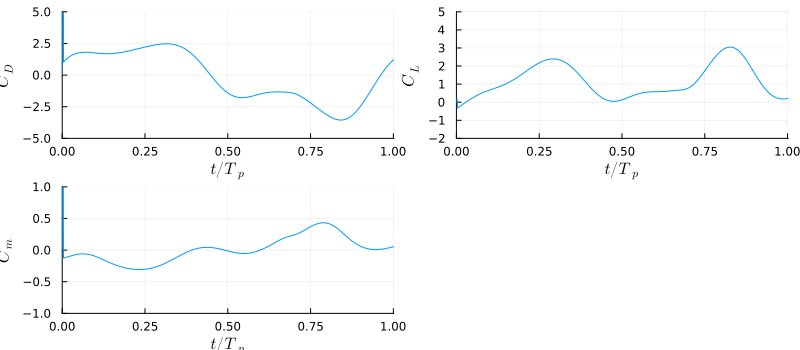

In [17]:
fx, fy = force(sol,sys,1;inertial=true);
mom = moment(sol,sys,1);

plot(
plot(sol.t/Tp,2*fx/Ω^2,xlim=(0,Inf),ylim=(-5,5),xlabel="\$t/T_p\$",ylabel="\$C_D\$",legend=:false),
plot(sol.t/Tp,2*fy/Ω^2,xlim=(0,Inf),ylim=(-2,5),xlabel="\$t/T_p\$",ylabel="\$C_L\$",legend=:false),
plot(sol.t/Tp,2*mom/Ω^2,xlim=(0,Inf),ylim=(-1,1),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*